# Trajectory analysis highlighting conformational change for different $V_\mathrm{TM}$

In [1]:
import pytraj as pt
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import numpy as np
import nglview as nv
import pandas as pd
import os
import mdtraj as md
import pickle
from tqdm.notebook import trange, tqdm

# Dictionary with collected data

In [2]:
with open(f"../RUNS.pkl", "rb") as f:
            RUNS = pickle.load(f)

In [6]:
## showcase structure of the dictionary
for key in RUNS:
    print(key, RUNS[key]["label"])

nof 0 mV
posf +200 mV
negf -200 mV
L80D 0 mV, L80D
L80D_field +200 mV, L80D
L80K 0 mV, L80K
L80K_field +200 mV, L80K
S188R 0 mV, S188R
S188R_field +200 mV, S188R
S188D 0 mV, S188D
S188D_field +200 mV, S188D


In [4]:
## contents for one runtype
## in the final dictionary
list(RUNS["nof"])

['label',
 'folder',
 'd_5_7',
 'd_2_10',
 'pore_dist_xy',
 'area',
 'fulltop',
 'n_lipids',
 'RoG',
 'rmsf_sliced',
 'mdtraj',
 'z_slices',
 'pore_dist_xy_boots_std']

# Load in trajectories

Assumes access to the full .xtc files, which cannot be supplied here due to filesize

In [ ]:
for key in tqdm(RUNS):
    RUNS[key]["pytrj"] = pt.iterload(
                    [RUNS[key]["folder"] + f"/{i}/prot_center_mol_fit_{i}.xtc" for i in [1,2,3]], 
                     RUNS[key]["folder"] + "step1_pdbreader.pdb", 
                     stride = 1)

# Average structure

In [47]:
def write_avg_frame(key, skip=10, overwrite=False):
    t = RUNS[key]["pytrj"][::skip]
    print(key, t)
    trj = pt.Trajectory()
    trj.top = RUNS[key]["pytrj"].top
    trj.append(pt.average_frame(
        pt.superpose(t, ref=0))
        )
    if True:
        pt.write_traj(f"{key}_avgframe.pdb", trj,
                      overwrite=overwrite)

In [ ]:
for key in RUNS:
    write_avg_frame(key, skip=1, overwrite=True)

# Pore diameter

In [317]:
## check that we selected the correct pore-lining ILE residues
[RUNS[key]["pytrj"].top.atom(i).resname for i in RUNS[key]["pytrj"].top.select("@CB&:278,191,86,405")]

['ILE', 'ILE', 'ILE', 'ILE']

In [ ]:
%%time
for key in tqdm(RUNS):
    RUNS[key]["d_5_7"] = pt.distance(RUNS[key]["pytrj"], 
                     ":278@CB :191@CB")
    RUNS[key]["d_2_10"] = pt.distance(RUNS[key]["pytrj"], 
                     ":86@CB :405@CB")

  0%|          | 0/11 [00:00<?, ?it/s]

# Distance from pore center

In [69]:
def dist_from_pore_center_of_geom(key, skip=10):
    CA_xyz = RUNS[key]["pytrj"][::skip]["@CA"].xyz ## ca positions for entire protein
    print("CA loaded")
    pore_cog = pt.center_of_geometry(RUNS[key]["pytrj"][::skip], mask = ":86,405,278,191") ## pore center
    print("pore loaded")
    xy_dist = CA_xyz[:,:,:2] - pore_cog[:,:2].reshape(len(pore_cog),1, 2) # distance from center as vector in xy 
    #print(key, " done")
    return np.linalg.norm(xy_dist,axis=2) # take norm over the xy axis


Visualize to check we correctly identify the pore

<IPython.core.display.Javascript object>


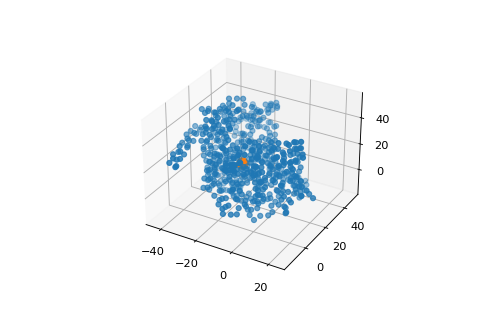

In [38]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(*RUNS[key]["pytrj"][::100]["@CA"].xyz[-1,:,:].T)
ax.scatter(*pt.center_of_geometry(RUNS[key]["pytrj"][::100], mask = ":86,405,278,191")[-1,:].T, s=100)
plt.show()

In [ ]:
for key in tqdm(RUNS):
    RUNS[key]["pore_dist_xy"] = dist_from_pore_center_of_geom(key, skip=5)

In [40]:
RUNS[key]["pore_dist_xy"].shape

(1501, 573)

In [25]:
def delta_dist(key, refkey="nof"):
    return RUNS[key]["pore_dist_xy"].mean(axis=0) - RUNS[refkey]["pore_dist_xy"].mean(axis=0)

Bootstrapped standard deviation of distance from the pore:

In [27]:
def resample_pore_dist(arr):
    
    def replace_sample(A):
        # https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array
        return A[np.random.choice(A.shape[0], A.shape[0], replace=True)]
    
    pore_dist_xy_key, pore_dist_xy_refkey = arr
    ## calc the diff of the mean for the resampled datasets
    return replace_sample(pore_dist_xy_key).mean(axis=0) - replace_sample(pore_dist_xy_refkey).mean(axis=0)

In [28]:
def bootstrap_pore_dist_std(arr, n_resample):
    boot = np.array([resample_pore_dist(data) for data in [arr]*n_resample]).std(axis=0)
    return boot

In [ ]:
for key in tqdm(list(RUNS)[:3]):
    RUNS[key]["pore_dist_xy_boots_std"] = bootstrap(
              (RUNS[key]["pore_dist_xy"], ),
              statistic=np.std,
              axis=0,
              n_resamples=50,
              #vectorized=False,
              confidence_level=0.95,
              random_state=1, 
              method='percentile',
         ).confidence_interval

Save results

In [ ]:
with open(f"RUNS.pkl", "wb") as f:
            pickle.dump({key: 
                            {
                                subk: RUNS[key][subk] for subk in RUNS[key] if subk!="pytrj"
                            } for key in RUNS
                        }, f)